# bias vs variance (偏差和方差)

前半部分实现一个正则化的线性回归利用水库中的水位变化来预测大坝中流出的水量，后半部分用调试比较偏差和方差。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
import seaborn as sns

In [2]:
def load_data(path):
    d = sio.loadmat(path)
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

In [4]:
X.shape, Xval.shape, Xtest.shape

((12,), (21,), (21,))

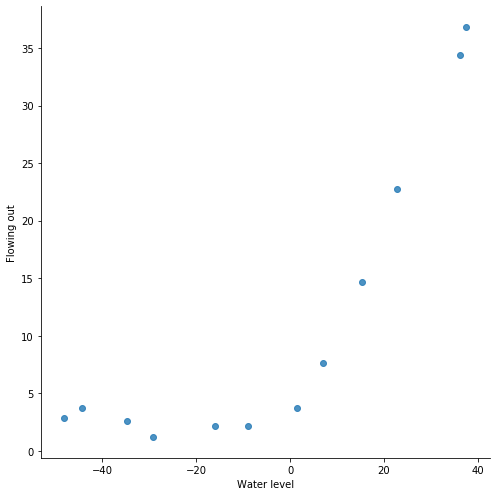

In [5]:
df = pd.DataFrame({'Water level': X, 'Flowing out': y})
sns.lmplot('Water level', 'Flowing out', data=df, fit_reg=False, height=7)
plt.show()

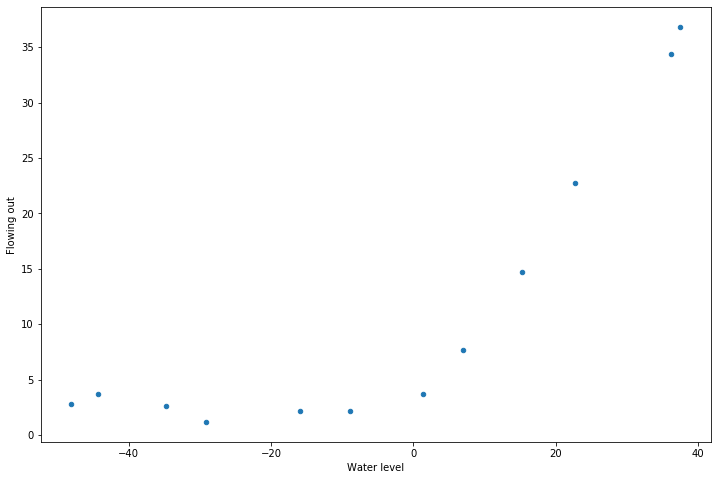

In [6]:
df.plot(kind='scatter', x='Water level', y='Flowing out', figsize=((12,8)))

In [7]:
X, Xval, Xtest = [np.insert(x.reshape(-1, 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

## cost function

![](img/cost.png)

In [8]:
def regularized_cost(theta, X, y, l=1):
    '''
    X: m*n
    y: m
    theta: n
    '''
    m = X.shape[0]
    inner = X @ theta.T - y
    first = inner @ inner.T / (2*m)
    
    tmp = np.array(theta)
    tmp[0] = 0
    second = tmp @ tmp.T * l / (2*m)
    
    return first + second

In [9]:
theta = np.ones(X.shape[1])
regularized_cost(theta, X, y)

303.9931922202643

## gradient

![](img/gradient.png)

In [10]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    tmp = np.array(theta)
    tmp[0] = 0
    ret = (X @ theta.T - y) @ X / m + l / m * tmp
    
    return ret

In [11]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

## Fitting linear regression

设置labda=0，因为线性回归模型中的lambda意义不大。

In [12]:
def linear_regression(X, y, l=1):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun=regularized_cost, x0=theta,
                      args=(X, y, l), method='TNC',
                      jac=regularized_gradient,
                      options={'disp': True})
    return res

In [13]:
theta = linear_regression(X, y, l=0).get('x')
theta

array([13.08790348,  0.36777923])

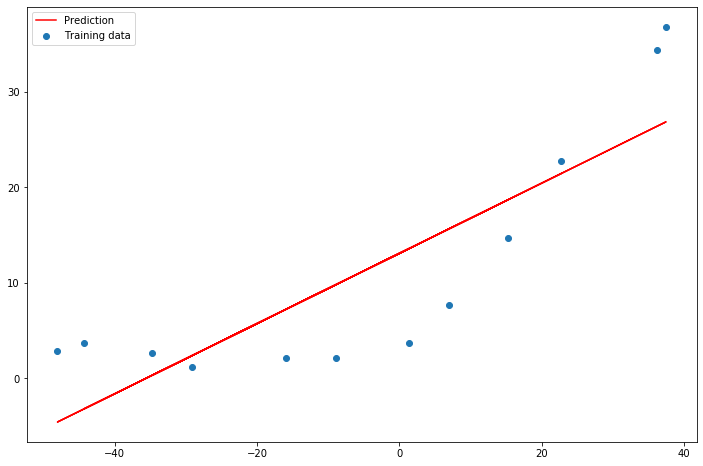

In [14]:
# ax + b
b = theta[0] # intercept
a = theta[1] # slope
x = X[:, 1:]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x, y, label='Training data')
ax.plot(x, a*x+b, label='Prediction', c='r')
ax.legend(loc='best')
plt.show()

## Learning curves

画出每一次训练和验证集的误差。

In [15]:
training_cost, cv_cost = [], []

In [16]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression(X[:i, :], y[:i], l=0)
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

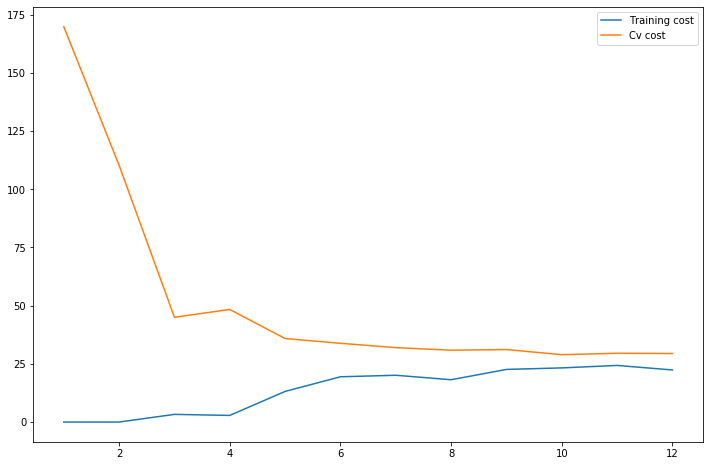

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(1, m+1), training_cost, label='Training cost')
ax.plot(np.arange(1, m+1), cv_cost, label='Cv cost')
ax.legend(loc='best')
plt.show()

从学习曲线上可以得到，这一个高偏差的模型（欠拟合），随着数据的增多训练集和验证集的误差都很高且接近。

## Polynomial regression

![](img/polynomial.png)

In [18]:
def normalize_feature(df):
    return df.apply(lambda col: (col - col.mean()) / col.std())
    # df = (df - df.mean()) / data.std()

In [19]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power+1)}
    df = pd.DataFrame(data)
    
    return df.values if as_ndarray else df

In [20]:
def prepare_poly_data(*args, power):
    '''
    args: X, Xval, Xtest
    '''
    
    def prepare(x):
        df = poly_features(x, power)
        ndarr = normalize_feature(df).values
#         ndarr = ((df - df.mean()) / df.std()).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [21]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

In [22]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [23]:
X_p, Xval_p, Xtest_p = prepare_poly_data(X, Xval, Xtest, power=8)
X_p[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## Learning curves

In [24]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    m = X.shape[0]
    training_cost, cv_cost = [], []
    
    for i in range(1, m+1):
        _x = X[:i, :]
        _y = y[:i]

        res = linear_regression(_x, _y, l=l)
        # 计算cost时不需要计算正则项，正则项只用于拟合
        tc = regularized_cost(res.x, _x, _y, l=0)
        cv = regularized_cost(res.x, Xval, yval, l=0)
        
        training_cost.append(tc)
        cv_cost.append(cv)
        
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(1, m+1), training_cost, label='Training cost')
    ax.plot(np.arange(1, m+1), cv_cost, label='Cv cost')
    ax.legend(loc='best', title=r'$\lambda={}$'.format(l) )
    plt.show()

lambda = 0，Trainning cost太低（过拟合）

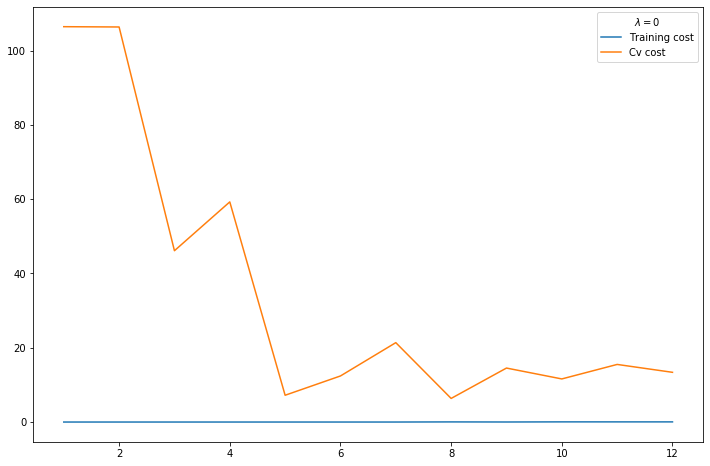

In [25]:
plot_learning_curve(X_p, y, Xval_p, yval, l=0)

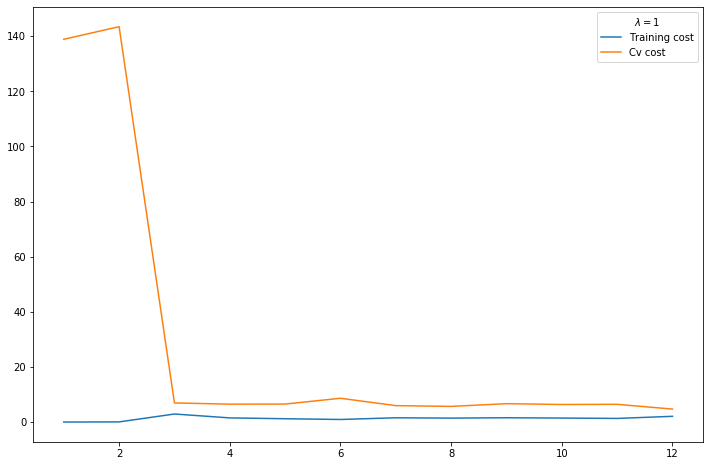

In [26]:
plot_learning_curve(X_p, y, Xval_p, yval, l=1)

lambda = 100

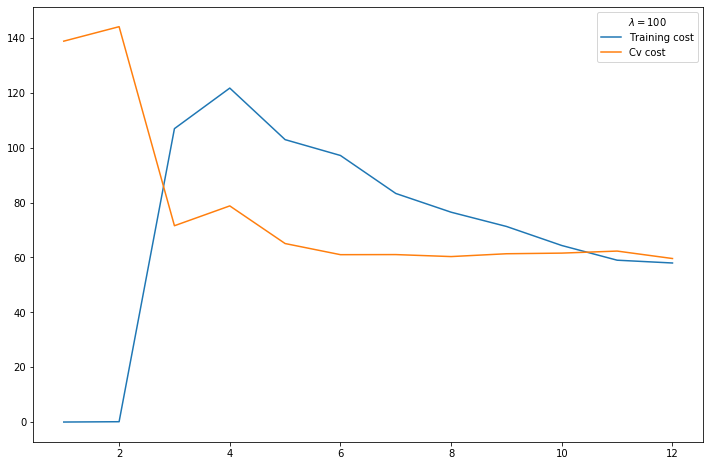

In [27]:
plot_learning_curve(X_p, y, Xval_p, yval, l=100)

## Selecting lambda

In [28]:
candidate_l = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost, test_cost = [], [], []

In [29]:
for l in candidate_l:
    res = linear_regression(X_p, y, l)
    tc = regularized_cost(res.x, X_p, y, l=0)
    cv = regularized_cost(res.x, Xval_p, yval, l=0)
    test_c = regularized_cost(res.x, Xtest_p, ytest, l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)
    test_cost.append(test_c)

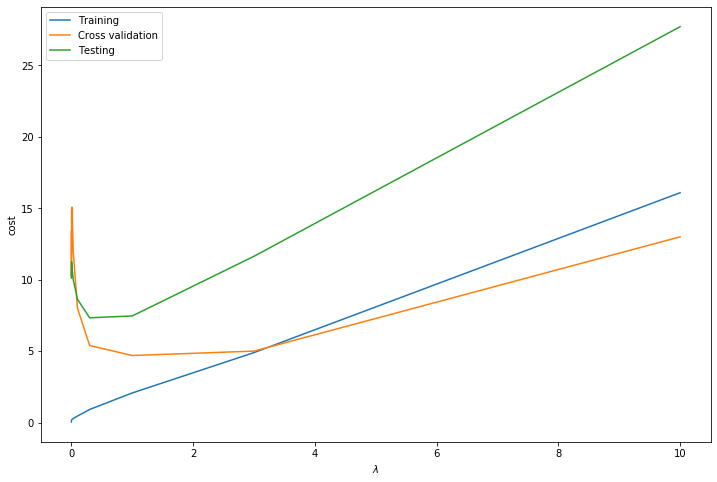

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(candidate_l, training_cost, label='Training')
ax.plot(candidate_l, cv_cost, label='Cross validation')
ax.plot(candidate_l, test_cost, label='Testing')
ax.legend(loc='best')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('cost')
plt.show()

In [31]:
# 从验证集中找，最优的lambda=1
candidate_l[np.argmin(cv_cost)]

1

In [32]:
# 从测试集中找，最优的lambda=0.3
candidate_l[np.argmin(test_cost)]

0.3